In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(0, 100)

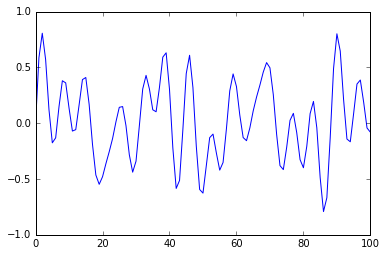

In [2]:
fso = 44100.0
upsample, downsample = (2, 11)
f = [1500.0, 4000.0, 6000.0, 7000.0]
lens = 2.0

f = np.array(f)[:, np.newaxis]
t = np.arange(0.0, lens, 1.0 / fso)[:, np.newaxis]
xarr = np.sin(2.0 * np.pi * f * t.T)
x = np.sum(xarr, axis=0)
x /= len(f)

plt.plot(x)
plt.xlim([0, 100])

In [78]:
upsample, downsample = (2, 3)
x = np.array([0.0, 0.5, 1.0, 0.5, 0.0, -0.5, -1.0, -0.5])
x = np.concatenate([list(x) * 16])
print x.shape
print x.dtype

(128L,)
float64


In [3]:
order = 8

from scipy.signal import iirfilter

iir_up_b, iir_up_a = iirfilter(order, 1.0 / upsample, btype='lowpass', ftype='butter')
iir_down_b, iir_down_a = iirfilter(order, 1.0 / downsample, btype='lowpass', ftype='butter')

In [7]:
def write_to_ring_buffer(ring_buffer, samples, write_idx):
    assert samples.shape[0] <= ring_buffer.shape[0]
    for i in xrange(samples.shape[0]):
        if write_idx == ring_buffer.shape[0]:
            write_idx = 0
        ring_buffer[write_idx] = samples[i]
        write_idx += 1
    return write_idx

def read_from_ring_buffer(ring_buffer, nsamples, read_idx):
    assert nsamples <= ring_buffer.shape[0]
    result = np.zeros(nsamples, dtype=np.float64)
    for i in xrange(nsamples):
        if read_idx == ring_buffer.shape[0]:
            read_idx = 0
        result[i] = ring_buffer[read_idx]
        read_idx += 1
    return read_idx, result

def calc_block_range(n, m, l):
    n = float(n)
    m = float(m)
    l = float(l)
    
    floor = lambda x: math.floor(x)
    ceil = lambda x: math.ceil(x)
    
    orig = [n, n]
    up = [m * orig[0], m * orig[1]]
    down = [floor(up[0] / l), ceil(up[1] / l)]
    reup = [l * down[0], l * down[1]]
    redown = [floor(reup[0] / m), ceil(reup[1] / m)]
    return int(redown[0]), int(redown[1])

In [8]:
from scipy.signal import lfilter, lfilter_zi

zup = lfilter_zi(iir_up_b, iir_up_a)
zdown = lfilter_zi(iir_down_b, iir_down_a)
down_offset = 0
redown_offset = 0
def process_block(block, block_size):
    global zup
    global zdown
    global iir_up_b
    global iir_up_a
    global iir_down_b
    global iir_down_a
    global down_offset
    global redown_offset
    global storage
    global delay
    
    # Upsample
    xup = np.zeros((upsample, block_size))
    xup[0] = block
    xup = xup.T.flatten()
    
    # Interpolate
    xinterp, zup = lfilter(iir_up_b, iir_up_a, xup, zi=zup)
    xinterp_len = xinterp.shape[0]
    assert xinterp_len == block_size * upsample
    
    # Manage edge conditions for downsampling
    xedge = xinterp[down_offset:]
    extra = xedge.shape[0] % downsample
    if extra > 0:
        xedge = np.concatenate([xedge, np.zeros(downsample - extra, dtype=np.float64)])
    assert xedge.shape[0] % downsample == 0
    down_offset = (downsample - ((xinterp_len - down_offset) % downsample))
    if down_offset == downsample:
        down_offset = 0
    
    # Decimate
    xdown = np.reshape(xedge, (-1, downsample))[:, 0]
    
    # Reupsample
    xreup = np.zeros((downsample, xdown.shape[0]))
    xreup[0] = xdown
    xreup = xreup.T.flatten()
    
    # Reinterpolate
    xreinterp, zdown = lfilter(iir_down_b, iir_down_a, xreup, zi=zdown)
    xreinterp_len = xreinterp.shape[0]
    
    # Manage edge conditions for redownsampling
    xreedge = xreinterp[redown_offset:]
    extra = xreedge.shape[0] % upsample
    if extra > 0:
        xreedge = np.concatenate([xreedge, np.zeros(upsample - extra, dtype=np.float64)])
    assert xreedge.shape[0] % upsample == 0
    redown_offset = (upsample - ((xreinterp_len - redown_offset) % upsample))
    if redown_offset == upsample:
        redown_offset = 0
    
    # Redownsample
    xrecons = np.reshape(xreedge, (-1, upsample))[:, 0]
    
    return xrecons

"""
upsample, downsample = (2, 3)
x = np.array([0.0, 0.5, 1.0, 0.5, 0.0, -0.5, -1.0, -0.5])
x = np.concatenate([list(x) * 4])
"""

block_size = 256

blockout_minlen, blockout_maxlen = calc_block_range(block_size, upsample, downsample)
delay = block_size - blockout_minlen
overflow = blockout_maxlen - block_size
storage_len = delay + block_size + overflow
#storage_len = blockout_maxlen - block_size + delay
storage = np.zeros(storage_len, dtype=np.float64)
read_idx = 0
write_idx = delay

xin = []
xout = []
for i in xrange(0, len(x), block_size):
    if i + block_size > len(x):
        break
    block = x[i:i + block_size]
    blockout = process_block(block, len(block))
    write_idx = write_to_ring_buffer(storage, blockout, write_idx)
    read_idx, blockdel = read_from_ring_buffer(storage, block_size, read_idx)
    xin.append(block)
    xout.append(blockdel)
xin = np.concatenate(xin)
xout = np.concatenate(xout)
print xin.shape
print xout.shape

(88064L,)
(88064L,)


(88064L,)
(88064L,)
[ 0.          0.          0.         ..., -0.00601035  0.00415928
  0.01064435]
8018.18181818


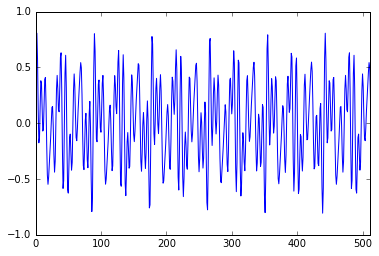

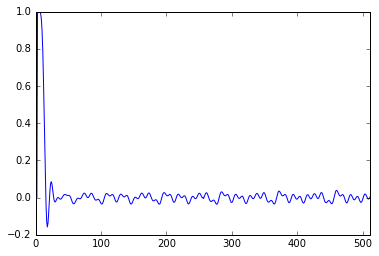

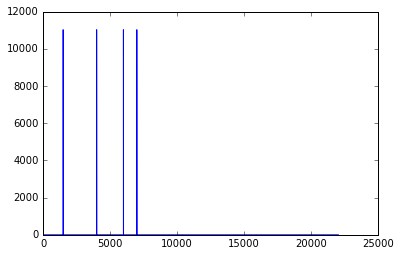

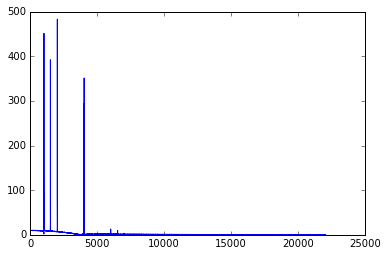

In [11]:
print xin.shape
print xout.shape

plt.figure()
plt.plot(x)
plt.xlim([0, 512])

plt.figure()
plt.plot(xout)
plt.xlim([0, 512])
print xout

plt.figure()
plt.plot(np.fft.rfftfreq(x.shape[0], d=1.0 / fso), np.abs(np.fft.rfft(x)))

print fso * (float(upsample) / downsample)
plt.figure()
plt.plot(np.fft.rfftfreq(xout.shape[0], d=1.0 / fso), np.abs(np.fft.rfft(xout)))

In [13]:
from IPython.lib.display import Audio

Audio(x / np.max(x), rate=fso)

In [14]:
Audio(xout / np.max(xout), rate=fso)

In [18]:
fso = 44100.0
upsample, downsample = (2, 11)
f = [1500.0, 4000.0, 2000.0, 1000.0]
lens = 2.0

f = np.array(f)[:, np.newaxis]
t = np.arange(0.0, lens, 1.0 / fso)[:, np.newaxis]
xarr = np.sin(2.0 * np.pi * f * t.T)
xcomp = np.sum(xarr, axis=0)
xcomp /= len(f)

Audio(xcomp / np.max(xcomp), rate=fso)